In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random

from torchvision.datasets import MNIST

from dataset_builder import *

In [107]:
train_loader, test_loader, mnist = prepare_semisupervised_mnist_data(subset_ratio = 0.4, train_ratio=0.75)

Dataset preparato:
- Subset totale: 24000 campioni
- Training set: 18000 campioni
- Test set: 6000 campioni
- Batch size: 32


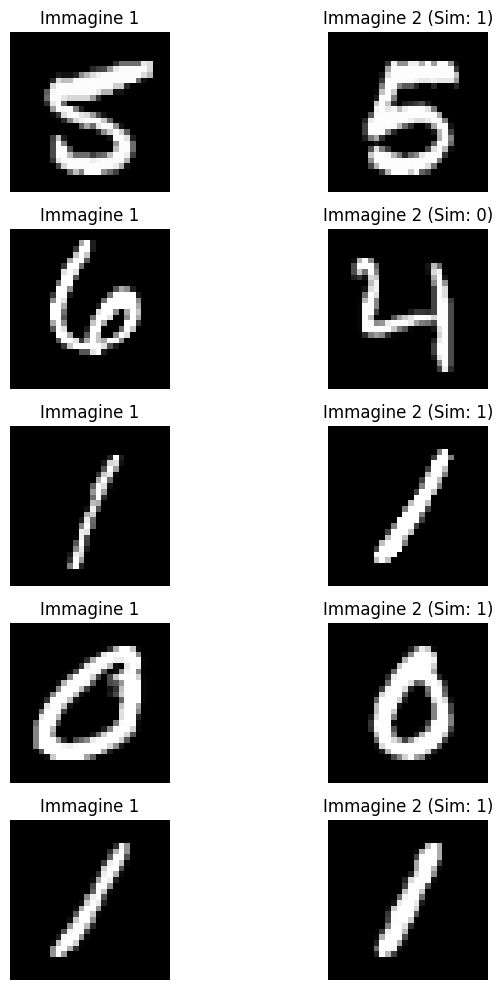

In [108]:
visualize_pairs(train_loader.dataset)

In [109]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0, w = 1): # prova ad aumentare il margin
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.w = w
    def forward(self, output1, output2, label):
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((label) * torch.pow(euclidean_distance, 2) +
                                    (1-label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))*self.w

      return loss_contrastive

In [110]:
class SiameseNetwork(nn.Module):
    def __init__(self, embedding_size = 2):
        super(SiameseNetwork, self).__init__()

        # CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2)
        )

        # fully connected layers
        self.fc1 = nn.Sequential(
            
            nn.Linear(256 * 3 * 3, 1024),
            nn.ReLU(inplace=True),

            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),

            nn.Linear(512, embedding_size)
        )

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [112]:
def train_model(model, train_loader, optimizer, criterion, epochs):

    counter = []
    loss_history = [] 
    iteration_number= 0

    for epoch in range(epochs):

        for i, (img0, img1, label) in enumerate(train_loader, 0):

            optimizer.zero_grad()
            output1, output2 = model(img0, img1)
            loss_contrastive = criterion(output1, output2, label)
            loss_contrastive.backward()
            optimizer.step()
            if i % 50 == 0 :
                print(f"Epoch {epoch} batch {i}\nloss {loss_contrastive.item()}\n")
                iteration_number += 10

                counter.append(iteration_number)
                loss_history.append(loss_contrastive.item())
    
    return (counter, loss_history)

In [113]:
net = SiameseNetwork(embedding_size = 128)
criterion = ContrastiveLoss(margin=3.0, w = 1)
optimizer = torch.optim.Adam(net.parameters(), lr = 0.00001)

counter, loss_history = train_model(net, train_loader, optimizer, criterion, epochs = 10)


Epoch 0 batch 0
loss 5.0584540367126465

Epoch 0 batch 50
loss 3.2479758262634277

Epoch 0 batch 100
loss 2.6762537956237793

Epoch 0 batch 150
loss 2.5579349994659424

Epoch 0 batch 200
loss 2.3417110443115234

Epoch 0 batch 250
loss 2.436643600463867

Epoch 0 batch 300
loss 2.4031550884246826

Epoch 0 batch 350
loss 2.381727457046509

Epoch 0 batch 400
loss 2.4995291233062744

Epoch 0 batch 450
loss 2.486086130142212

Epoch 0 batch 500
loss 2.352097988128662

Epoch 0 batch 550
loss 2.53643798828125

Epoch 1 batch 0
loss 2.447272777557373

Epoch 1 batch 50
loss 2.542346715927124

Epoch 1 batch 100
loss 2.4468514919281006

Epoch 1 batch 150
loss 2.1752631664276123

Epoch 1 batch 200
loss 2.386493682861328

Epoch 1 batch 250
loss 2.3677947521209717

Epoch 1 batch 300
loss 2.3488504886627197

Epoch 1 batch 350
loss 2.318444013595581

Epoch 1 batch 400
loss 2.336848497390747

Epoch 1 batch 450
loss 2.351896047592163

Epoch 1 batch 500
loss 2.172727584838867

Epoch 1 batch 550
loss 2.37408

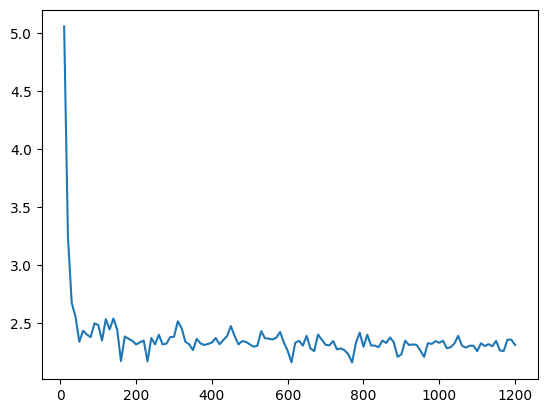

In [114]:
plt.plot(counter, loss_history)

In [43]:
def test_trained_model(model, dataset, num_examples=5):
    """
    Testa il modello trainato su alcuni esempi
    """
    giuste = 0
    sbagliate = 0
    model.eval()
    device = next(model.parameters()).device
    
    print(f"Test del modello testato su {num_examples} esempi:")
    print("-" * 60)
    
    for i in range(num_examples):
        img1, img2, true_label = dataset[i]
        
        # Aggiungi dimensione batch
        img1 = img1.unsqueeze(0).to(device)
        img2 = img2.unsqueeze(0).to(device)
        
        with torch.no_grad():
            output1, output2 = model(img1, img2)
            euclidean_distance = F.pairwise_distance(output1, output2)
            similarity = torch.exp(-euclidean_distance)
            predicted_label = 1 if similarity.item() > 0.5 else 0
        
        if predicted_label == true_label:
            giuste +=1
        else:
            sbagliate +=1
    
    print("Il modello ne ha beccate: " + str(giuste))
    print("Il modello ne ha sbagliate: " + str(sbagliate))



In [133]:
test_trained_model(net, test_loader.dataset, num_examples=100)
print("porcodio")

Test del modello testato su 100 esempi:
------------------------------------------------------------
Il modello ne ha beccate: 50
Il modello ne ha sbagliate: 50
porcodio
